In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 
import glob

import tqdm

from nd2reader import ND2Reader
import h5py
import pickle
import json

import datetime

import warnings
warnings.filterwarnings('ignore')

import ffmpeg

from skimage.filters import rank, threshold_otsu, threshold_local#
from skimage import morphology

import scipy 
import skimage

import pandas as pd
import seaborn as sns
import csv

from tools.func import *

In [3]:
#Draw rectangle to images
def mousePoints(event,x,y,flags,param):
    #Crop image
    global refPt
    global img
    global final_boundaries
    global stopper
    # Left button click
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
    elif event == cv2.EVENT_LBUTTONUP:
        refPt.append((x, y))
        final_boundaries.append((refPt[0],refPt[1]))
        stopper = True
        cv2.imshow("win", img)
        print("two clicks!")
    elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
        clone = img.copy()
        cv2.rectangle(clone, refPt[0], (x, y), (0, 255, 0), 4)
        cv2.imshow("win", clone)



def parse_raw_dict(day, video_path, own_meta):

    fh = video_path

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    label_map = None

    if isinstance(fh, str):
        if not fh.endswith(".nd2"):
            raise InvalidFileType(
                ("The file %s you want to read with nd2reader" % fh)
                + " does not have extension .nd2."
            )
        
        filename = fh

        fh = open(fh, "rb")

    _fh = fh
    _fh.seek(-8, 2)
    chunk_map_start_location = struct.unpack("Q", _fh.read(8))[0]
    _fh.seek(chunk_map_start_location)
    raw_text = _fh.read(-1)
    label_map = LabelMap(raw_text)
    datasTT = RawMetadata(_fh, label_map)


    seeding_density = []
    well_name = []
    well_info = datasTT.image_metadata[b'SLxExperiment'][b'ppNextLevelEx'][b''][b'uLoopPars'][b'Points'][b'']
    for i in range(len(well_info)):
        
        label = (well_info[i][b'dPosName']).decode("utf8")
        lable_parts = label.split("_")
        if len(lable_parts) == 1:
            seeding_density.append(500)
        else:
            try:
                seeding_density.append(int(lable_parts[1]))
            except:
                seeding_density.append(500)
                print(lable_parts[1])

        well_name.append(lable_parts[0])

    own_meta[day]["cell"] = well_name
    own_meta[day]["seeding_density"] = seeding_density
    own_meta[day]["dt"] = datasTT.image_metadata[b'SLxExperiment'][b'uLoopPars'][b'dPeriod']*1e-3

    return own_meta
        

In [6]:
target_paths

[]

In [9]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)

root_path = "F:/instru_projects/TimeLapses/u-wells/*"
target_paths = glob.glob(os.path.join(root_path, "*.nd2"))
coord_dict = {}

skip_existing = False
map_coord = True

for video_path in target_paths:

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])
    matrix = parts[2]
    n_ines = parts[3][0]
    start_time = int(parts[4][:-1])
    comments = parts[5][:-3]

    if day not in own_meta.keys():
        own_meta[day] = {}
    elif skip_existing:
        continue

    own_meta[day]["matrix"]  = matrix
    own_meta[day]["n_cells"]  = n_ines
    own_meta[day]["dim"] = "3D"
    own_meta[day]["incubation_time"] = start_time
    own_meta[day]["other"] = "other"

    own_meta = parse_raw_dict(day, video_path, own_meta)
    
    if map_coord:

        with ND2Reader(video_path) as images:

            coords = []
            final_boundaries = []
            metas = load_metadata(images)
            z_levels = metas["n_levels"]
            vis_level = int(z_levels/2)
            stopper = False

            for i in range(metas["n_fields"]):

                cv2.namedWindow('win',cv2.WINDOW_NORMAL)
                cv2.setMouseCallback("win", mousePoints)

                img = images.get_frame_2D(c=0, t=0, z=vis_level, x=0, y=0, v=i)
                cv2.imshow("win",img)

                k = cv2.waitKey(0)

                if k == ord("q"):  # Press q to quit
                    break

                if stopper == True:

                    stopper = False
                    coords.append(final_boundaries)
                    final_boundaries = []
                    cv2.destroyAllWindows()


            cv2.destroyAllWindows()

            if k == ord("q"):  # Press q to quit
                break

        final_coords = []

        for i in range(len(coords)):
            final_coords.append([[coords[i][0][0][0], coords[i][0][0][1]], [coords[i][0][1][0], coords[i][0][1][1]]])

        
        own_meta[day]["coords"] = final_coords
        
        if k == ord("q"):  # Press q to quit
            break


    with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
        json.dump(own_meta, f, ensure_ascii=False, indent=4)


two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
new
new
two clicks!
two clicks!
two clic

In [10]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

for video_path in target_paths:

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])
    own_meta = parse_raw_dict(day, video_path, own_meta)

    with ND2Reader(video_path) as images:
        metas = load_metadata(images)

    for k in metas.keys():
        own_meta[day][k] = metas[k]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)


new
new


In [31]:
with open('C:/Users/lehtona6/codes/InstruProject/NikonPipes/dataStore/metalib.json', 'r') as f:
  own_meta = json.load(f)

scaler = 350


for video_path in tqdm.tqdm(target_paths, total=len(target_paths)):

    video_name = os.path.split(video_path)[-1][:-4]
    results = os.path.join(root_path, "results_{}".format(video_name))
    os.makedirs(results, exist_ok=True)

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    coords = own_meta[day]["coords"]

    loc_id = 0
    t_id = 0
    channel = "BF"
    track_list = []
    total_dict = {}

    out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id), datetime.date.today() ) )
    #out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 20, (2304,2304))
    out_process = ( 
    ffmpeg 
    .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
    .format(2304, 2304)) 
    .output(out_name, pix_fmt='yuv420p') .overwrite_output() 
    .run_async(pipe_stdin=True) 
    )

    with ND2Reader(video_path) as images:
        #c -channel, v - locations, t - time
        
        metas = load_metadata(images)
        images.iter_axes = "vt"
        images.bundle_axes = "zyx"
        area_th = int(40/metas["m"])**2*np.pi

        vis_level = int(metas["n_levels"]/2)
        frames_tot = int((metas["n_channels"]*metas["n_fields"]*metas["n_frames"]))

        x_final = coords[loc_id][0] #(0,2304)
        y_final = coords[loc_id][1] #(2304,0) 


        for idx, img in tqdm.tqdm(enumerate(images),total=frames_tot):

            c_id = idx%metas["n_channels"]
            id_name = metas["channels"][c_id]


            if (id_name != channel) : #| (loc_id != 1)
                #t_id += 1
                #if t_id == metas["n_frames"]:
                #    t_id = 0
                #    loc_id += 1
                continue

            projected_frame =  np.min(img, axis = 0)

            th = np.percentile(projected_frame.flatten(),5)
            projected_frame[projected_frame>th] = 0
            x, y, r, area, x_start, y_start, mask = process_frame(projected_frame, x_final, y_final)

            if area < area_th:
                print("No object found")
            else:
                x_final = x_start
                y_final = y_start

            focus_level = 1e10
            focus_idx = 0

            for i in range(img.shape[0]):

                current_frame = img[i].copy()
                cropped = current_frame[x_final[1]:y_final[1], x_final[0]:y_final[0]]
                
                if (cropped.shape[0] == 0) or (cropped.shape[1] == 0):
                    lap = np.inf
                else:
                    lap = cv2.Laplacian(cropped, cv2.CV_64F).var()

                if focus_level > lap:

                    focus_level = lap
                    focus_idx = i

            int_frame = (img[focus_idx]*2**8/(2**16)).astype("uint8")
            int_frame = np.stack((int_frame,int_frame,int_frame), axis = -1)
            img_normalized = cv2.normalize(int_frame, None, 0, 255, cv2.NORM_MINMAX)
            img_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)
            cv2.rectangle(img_normalized, x_start, y_start, (2**16,0,0), 5)
            int_mask = (mask.astype(bool)*255).astype("uint8")
            int_mask = np.stack((int_mask,int_mask,int_mask), axis = -1)
            out_vis = cv2.addWeighted(img_normalized,1.0,int_mask,0.75,0)

            #plt.imshow(out_vis)
            #plt.show()

            out_process.stdin.write(out_vis)
            #out_process.write(out_vis)
                
            track_list.append([x*metas["m"], y*metas["m"], r*metas["m"], area*metas["m"]**2, (focus_idx-1)*metas["z_step"], mask])
            t_id += 1

            if t_id == metas["n_frames"]:

                total_dict = pile_data(track_list, total_dict, loc_id, channel)

                out_process.stdin.close()
                out_process.wait()
                #out_process.release()

                with open(os.path.join(results,'{}_detections.pkl'.format(os.path.split(video_path)[1][:-4])), 'wb') as f:
                    pickle.dump(total_dict, f)

                t_id = 0
                loc_id += 1
                track_list = []
                if loc_id == metas["n_fields"]:
                    break
                
                x_final = coords[loc_id][0] #(0,2304)
                y_final = coords[loc_id][1] #(2304,0) 

                #if loc_id == 2:
                #    break
                
                out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id), datetime.date.today() ) )
                #out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 20, (2304,2304))
                out_process = ( 
                ffmpeg 
                .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
                .format(2304, 2304)) 
                .output(out_name, pix_fmt='yuv420p') .overwrite_output() 
                .run_async(pipe_stdin=True) 
                )

    out_process.stdin.close()
    out_process.wait()
    #out_process.release()


  0%|          | 0/2 [00:00<?, ?it/s]

No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


 50%|█████     | 1/2 [07:23<07:23, 443.41s/it]

No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


No object found


100%|██████████| 2/2 [12:51<00:00, 385.93s/it]


In [13]:
day = "230417"

with open('./dataStore/metalib.json', 'r') as f:
    own_meta = json.load(f)

own_meta[day]["ignore"] = [1]

with open('./dataStore/metalib.json', 'w', encoding='utf-8') as f:
    json.dump(own_meta, f, ensure_ascii=False, indent=4)

In [4]:
all_paths

['E:/instru_projects/TimeLapses/u-wells\\collagen\\240307_timelapses_collagen_3lines_72h_spheroidseeded.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\collagen\\240304_timelapses_collagen_3lines_91h_spheroidseeded.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\IPN\\230417_timelapses_IPN3mM_3lines_63h_culture.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\IPN\\240502_Uwell_IPN_40mM2mgml_48h_spheroid_culture001.nd2',
 'E:/instru_projects/TimeLapses/u-wells\\IPN\\240426_Uwell_IPN_3mM2mgml_48h_spheroid_15h_culture005.nd2',
 'F:/instru_projects/TimeLapses/u-wells\\collagen\\240226_timelapses_collagen_3lines_72h_spheroidseeded.nd2',
 'F:/instru_projects/TimeLapses/u-wells\\collagen\\240301_timelapses_collagen_3lines_110h_spheroidseeded.nd2',
 'F:/instru_projects/TimeLapses/u-wells\\collagen\\240301_timelapses_collagen_3lines_48h_spheroidseeded.nd2',
 'F:/instru_projects/TimeLapses/u-wells\\collagen\\240304_timelapses_collagen_3lines_115h_spheroidseeded.nd2',
 'F:/instru_projects/TimeLapses/u

In [19]:
all_paths = glob.glob("E:/instru_projects/TimeLapses/u-wells/*/*.nd2") + glob.glob("F:/instru_projects/TimeLapses/u-wells/*/*.nd2")



In [21]:
total_ID = 0

for global_counter, video_path in enumerate(all_paths):

    video_name = os.path.split(video_path)[-1][:-4]
    results = os.path.join(os.path.split(video_path)[0], "results_{}".format(video_name))
    pickel_path = os.path.join(results,"{}_detections.pkl".format(video_name))

    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    with open('./dataStore/metalib.json', 'r') as f:
        own_meta = json.load(f)

    with open(pickel_path, 'rb') as f:
        total_dict = pickle.load(f)
        

    for counter, current_key in enumerate(total_dict.keys()):
        try:
            loc_ = int(current_key.split("_")[1])
            df_temp = pd.DataFrame()
            df_temp["x"] = np.array(total_dict[current_key]['x'])*own_meta[day]["m"]
            df_temp["y"] = np.array(total_dict[current_key]['y'])*own_meta[day]["m"]
            df_temp["z"] = np.array(total_dict[current_key]['z'])*own_meta[day]["z_step"]

            df_temp["t"] = np.arange(df_temp.shape[0])*own_meta[day]["dt"]+own_meta[day]["incubation_time"]
            df_temp["area"] = np.array(total_dict[current_key]['area'])*own_meta[day]["m"]
            df_temp["cell_label"] = own_meta[day]["cell"][loc_]
            df_temp["matrix"] = own_meta[day]["matrix"]
            df_temp["seeding_density"] = own_meta[day]["seeding_density"][loc_]
            df_temp["ID"] = total_ID
            total_ID += 1

            df_temp["MSD_tau"] = np.zeros(df_temp.shape[0])
            df_temp["t"] = np.zeros(df_temp.shape[0])

            for tau in range(1, df_temp.shape[0]):
                MSD = calc_MSD(df_temp, own_meta[day]["dt"], tau)
                df_temp.loc[tau,"MSD_tau"] = MSD
                df_temp.loc[tau,"t"] = tau*own_meta[day]["dt"]

            try:
                p, p_ = scipy.optimize.curve_fit(power_law, df_temp["t"], df_temp["MSD_tau"],  maxfev = 10000)
                df_temp["alpha"] = p[1]
                df_temp["ampltiude"] = p[0]
            except:
                print("failed", current_key)
                df_temp["alpha"] = 0#np.nan
                df_temp["ampltiude"] = 0#np.nan
        except:
            print("broken file", video_name, current_key)


        if counter == 0:
            df_meas = df_temp
        else:
            df_meas = pd.concat([df_meas,df_temp])

    if global_counter == 0:
        df = df_meas
    else:
        df = pd.concat([df, df_meas])

failed loc_12_ch_BF
broken file 240304_timelapses_collagen_3lines_115h_spheroidseeded loc_19_ch_BF
broken file 240304_timelapses_collagen_3lines_48h_spheroidseeded loc_19_ch_BF


In [24]:
df.loc[df["cell_label"] == "T", "cell_label"] = "MCF10AT"
df.loc[df["cell_label"] == "MCFA10A", "cell_label"] = "MCF10A"
df.loc[df["cell_label"] == "MCFA10", "cell_label"] = "MCF10A"
df.loc[df["cell_label"] == "DCIS", "cell_label"] = "DCIS.COM"


df = df.reset_index()

<Axes: xlabel='cell_label', ylabel='MSD_tau'>

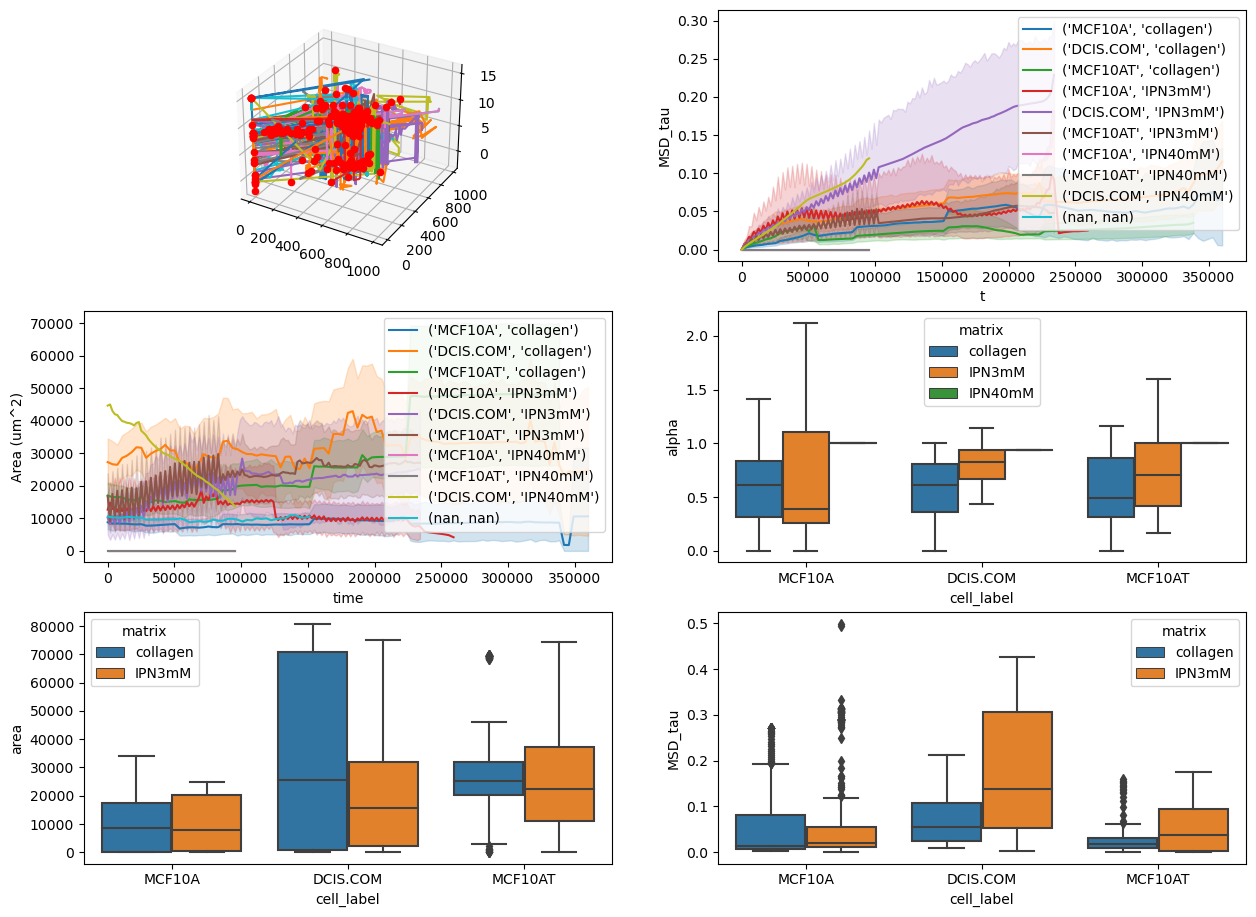

In [57]:

fig = plt.figure(figsize = (15,15))

ax = [ 
    fig.add_subplot(421, projection='3d'),
    fig.add_subplot(422),
    fig.add_subplot(423),
    fig.add_subplot(424),
    fig.add_subplot(425),
    fig.add_subplot(426)
]
for tags, data in df.groupby(["cell_label", "matrix", "ID"]):
    ax[0].plot3D(data["x"],  data["y"],data["z"])
    ax[0].scatter(data["x"].values[0],  data["y"].values[0],(data["z"]).values[0], label = False, color ="red")
    
    #ax[1].scatter(data["t"], data["MSD_tau"])
    x_data = np.arange(0,data["t"].values[-1], 10)
    y_data = power_law(x_data, data["ampltiude"].values[0], data["alpha"].values[0])
    #ax[1].plot(x_data, y_data, color = "red")


sns.lineplot(x = "t", y = "MSD_tau", hue =df[['cell_label', 'matrix']].apply(tuple, axis=1), data = df, ax = ax[1])

#ax[1].set_xlabel("time lag (s)")
#ax[1].set_ylabel("MSD")


sns.lineplot(x = "t", y = "area", hue = df[['cell_label', 'matrix']].apply(tuple, axis=1), data = df, ax = ax[2])
ax[2].set_xlabel("time")
ax[2].set_ylabel("Area (um^2)")

sns.boxplot(x = "cell_label", y= "alpha", data = df, hue = "matrix" ,ax = ax[3], showfliers = False)

mm = df.groupby(["cell_label", "matrix"]).mean().reset_index()
mm = df[(df["t"].values > 150000) & (df["t"].values < 250000)].reset_index()

sns.boxplot(x = "cell_label", y = "area", data = mm, hue = "matrix", ax = ax[4])
sns.boxplot(x = "cell_label", y = "MSD_tau", data = mm, hue = "matrix", ax = ax[5])

In [58]:
df.to_csv("./dataStore/tracked_all.csv")